<a href="https://colab.research.google.com/github/qlndzt/Price_prediction_for_Singaporean_Resale_Data/blob/main/0424_IT5100F_Group5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Problem Definition

### Background

Singapore's housing market is unique due to its high population density, limited land availability, and significant government involvement through the Housing & Development Board (HDB). Over recent years, there have been fluctuations in resale prices influenced by various economic, demographic, and policy factors.

Given the importance of housing decisions to individual financial stability and the overall economic health of Singapor, our project aims to leverage historical data to better understand and predict future trends in this market. This is particularly important for prospective homebuyers who need to make informed decisions in a competitive and often costly market environment.

### Stakeholder Benefits

Potential Homebuyers: Gain insights into when might be the best time to buy, what locations offer the best value, and how future trends could affect their investments.
Real Estate Professionals: Equip agents and brokers with better market understanding and forecasting tools to advise their clients more effectively.

### Define the Objectives of the Analysis

Predictive Accuracy: To develop highly accurate predictive models that can forecast future housing price trends using historical resale flat prices.

Insight Generation: To generate actionable insights that guide potential homebuyers in making informed decisions based on price trends, market forecasts, and other relevant economic indicators.

Decision Support: To provide a robust decision-support tool for real estate stakeholders (buyers, real estate agents, policymakers) to understand and respond to market dynamics effectively.

###Objectives for the Data Pipeline
Data Integration and Processing: Integrate and cleanse data sets to prepare for in-depth analysis and modeling.
Modeling and Forecasting: Utilize machine learning models (like XGBoost, Random Forest, Time Series Analysis) to predict housing price trends, helping buyers and other stakeholders understand potential market changes.

# 2. Data Collection

The data source we use is the Government Housing and Development Board website at data.gov.sg, which provides datasets related to housing, including resale prices, new housing sales, rental data, and demographic information. This is useful for various analytical tasks such as price predictions, market trends, etc.

Then we chose the data set containing historical data about resale flat prices.

We downloaded the data directly from the website, uploaded it to Google Drive,  and connected to Google Drive in Google Colab.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

# 3. Data Preprocess

In [ ]:
df.tail()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
177453,2024-04,YISHUN,EXECUTIVE,652,YISHUN AVE 4,07 TO 09,181.0,Apartment,1992,67 years 03 months,1080000.0
177454,2024-04,YISHUN,EXECUTIVE,392,YISHUN AVE 6,07 TO 09,142.0,Apartment,1988,63 years 03 months,780888.0
177455,2024-04,YISHUN,EXECUTIVE,324,YISHUN CTRL,04 TO 06,146.0,Apartment,1988,63 years 04 months,830000.0
177456,2024-04,YISHUN,EXECUTIVE,326,YISHUN RING RD,04 TO 06,146.0,Maisonette,1988,63 years 04 months,880000.0
177457,2024-04,YISHUN,EXECUTIVE,826,YISHUN ST 81,04 TO 06,146.0,Maisonette,1988,62 years 10 months,900000.0


There are various types of storey range. We will simplify them into 3 categories small, medium and big.

In [ ]:
def categorize_storey_range(range_str):
    # Extract the upper bound of the range
    upper_bound = int(range_str.split(' TO ')[1])

    # Define the categories based on upper bound
    if upper_bound <= 6:
        return 'Small'
    elif upper_bound <= 12:
        return 'Medium'
    else:
        return 'Big'

# Convert storey_range to simplier representation
df['storey_range'] = df['storey_range'].apply(categorize_storey_range)

print(df['storey_range'].value_counts())

storey_range
Small     72100
Medium    70389
Big       34969
Name: count, dtype: int64


We wil drop block and street_name since they are too specific.

In [ ]:
# We will be working on town, so remove block and street name
df = df.drop(columns = ['block', 'street_name'])

Convert string in 'remaining_lease'

In [ ]:
def convert_remaining_lease_to_years(lease_str):
    parts = lease_str.split()
    years = int(parts[0]) if parts[0].isdigit() else 0
    months = int(parts[2]) if len(parts) > 2 and parts[2].isdigit() else 0
    total_years = years + months / 12
    return total_years

In [ ]:
# Convert remaing_lease to numeric representation
df['remaining_lease'] = df['remaining_lease'].apply(convert_remaining_lease_to_years)

In [ ]:
# Check for missing values
df.isna().sum()

month                  0
town                   0
flat_type              0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

In [ ]:
# Count occurrences of each value in the flat_type
flat_counts = df['flat_type'].value_counts()

print(flat_counts)

flat_type
4 ROOM              74854
5 ROOM              44202
3 ROOM              41925
EXECUTIVE           13211
2 ROOM               3122
MULTI-GENERATION       78
1 ROOM                 66
Name: count, dtype: int64


Since ther are only few rows for 'MULTI_GENERATION' and '1 ROOM'. We droped 'MULTI_GENERATION' and combine '1 ROOM' and '2 ROOM' into 'SMALL UNIT'

In [ ]:
# Drop column multi-generation

df = df[df['flat_type'] != 'MULTI-GENERATION']

# Combine '1 ROOM' and '2 ROOM' into 'SMALL UNIT'
df['flat_type'] = df['flat_type'].replace({'1 ROOM': 'SMALL UNIT', '2 ROOM': 'SMALL UNIT'})

The original 'date' column is combination of month and year. We seperated it into two columns 'year' and 'month' and renamed the 'month' as 'date'

In [ ]:
# Rename 'month' column to 'date'
df.rename(columns={'month': 'date'}, inplace=True)

# Split the 'date' column into 'year' and 'month' columns
df['year'] = df['date'].apply(lambda x: x.split('-')[0])
df['month'] = df['date'].apply(lambda x: x.split('-')[1])


Prepare a time series with index of 'date' column.

In [ ]:
# Index the df with date
df['date'] = pd.to_datetime(df['date'])
time_series = df.copy()
time_series['date'] = pd.to_datetime(time_series['year'].astype(str) + '-' + time_series['month'].astype(str))
time_series.set_index('date', inplace=True)
df_t=time_series.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder

Label encoding all category columns

In [ ]:
df_labelencoded = df.copy()
df_labelencoded.drop(columns = ['date'], inplace=True)
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
df_labelencoded['town'] = label_encoder.fit_transform(df_labelencoded['town'])
df_labelencoded['flat_type'] = label_encoder.fit_transform(df_labelencoded['flat_type'])
df_labelencoded['storey_range'] = label_encoder.fit_transform(df_labelencoded['storey_range'])
df_labelencoded['flat_model'] = label_encoder.fit_transform(df_labelencoded['flat_model'])
df_labelencoded['remaining_lease'] = label_encoder.fit_transform(df_labelencoded['remaining_lease'])

In [ ]:
# Convert all data to numeric, coercing errors to NaN
df_labelencoded = df_labelencoded.apply(pd.to_numeric, errors='coerce')

Plot the correlation heatmap and calculate VIF values to find highly correlated columns

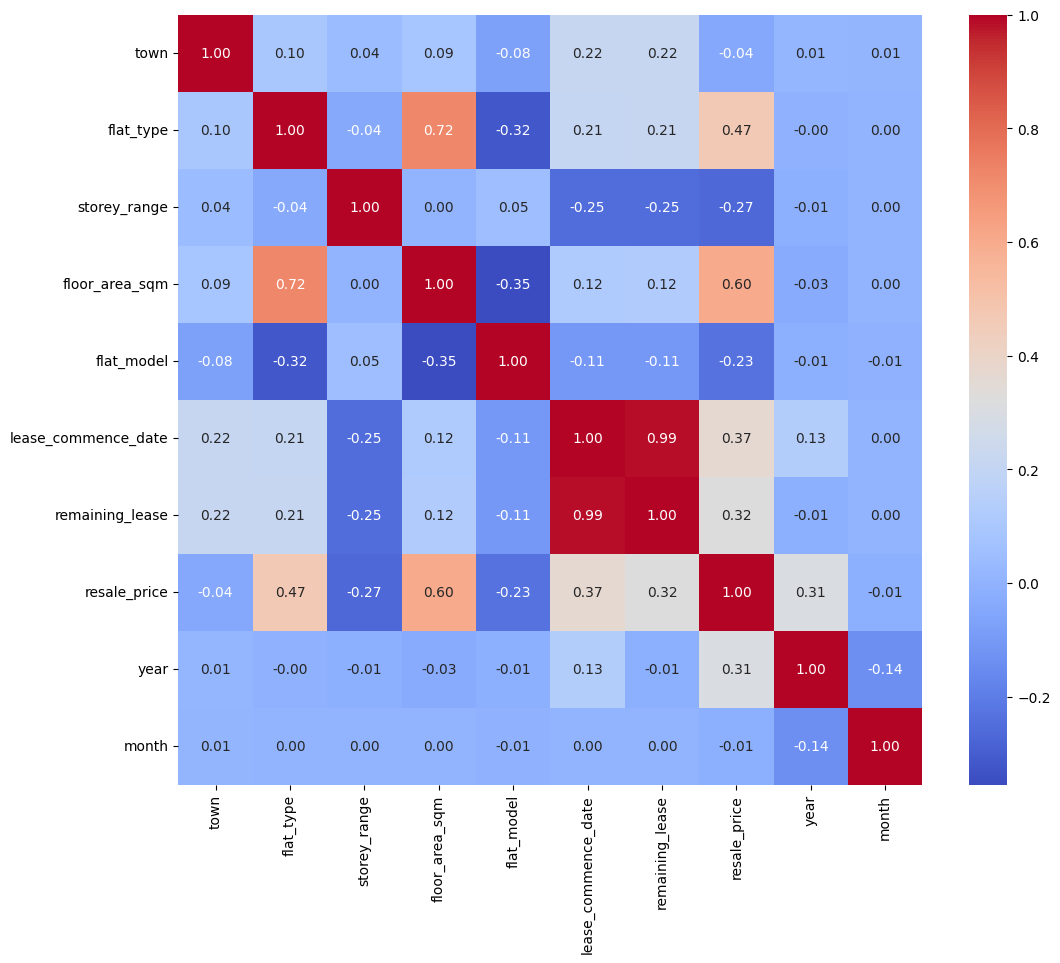

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_labelencoded.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [ ]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Add a constant term for the intercept
df_constant = add_constant(df_labelencoded)

# Calculate VIF for each feature
vif_data_rental = pd.DataFrame()
vif_data_rental["Feature"] = df_constant.columns
vif_data_rental["VIF"] = [variance_inflation_factor(df_constant.values, i) for i in range(df_constant.shape[1])]

# Display the VIF values
print(vif_data_rental)

                Feature           VIF
0                 const  1.227344e+06
1                  town  1.116049e+00
2             flat_type  2.144839e+00
3          storey_range  1.182885e+00
4        floor_area_sqm  3.043022e+00
5            flat_model  1.164262e+00
6   lease_commence_date  2.404936e+03
7       remaining_lease  2.360829e+03
8          resale_price  2.471208e+00
9                  year  5.268319e+01
10                month  1.989900e+00


In [ ]:
df_labelencoded.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month
0,0,4,1,44.0,5,1979,235,232000.0,2017,1
1,0,0,2,67.0,11,1978,226,250000.0,2017,1
2,0,0,2,67.0,11,1980,248,262000.0,2017,1
3,0,0,2,68.0,11,1980,244,265000.0,2017,1
4,0,0,2,67.0,11,1980,248,265000.0,2017,1


# 4. Exploratory data analysis (EDA)

We aggregates the DataFrame by date, computing the mean resale price for each period, and then plots these averages over time using a line plot. There is a clear patter of price before and after 2020-05

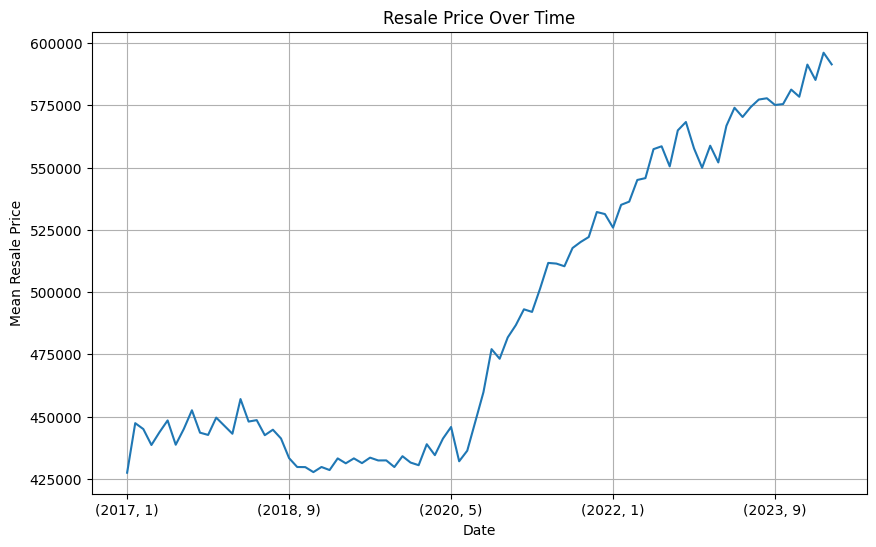

In [ ]:
df_resale_aggregated = df_labelencoded.groupby(['year', 'month']).mean()

# Plotting
df_resale_aggregated['resale_price'].plot(kind='line', figsize=(10, 6))

plt.title('Resale Price Over Time')
plt.xlabel('Date')
plt.ylabel('Mean Resale Price')
plt.grid(True)
plt.show()


We plotted boxplot that displays the distribution of resale_price for each year in the dataset, with the x-axis representing the year (converted to string type) and the y-axis showing the range of prices.

 It helping identify trends, outliers, or shifts in the property market over the years.

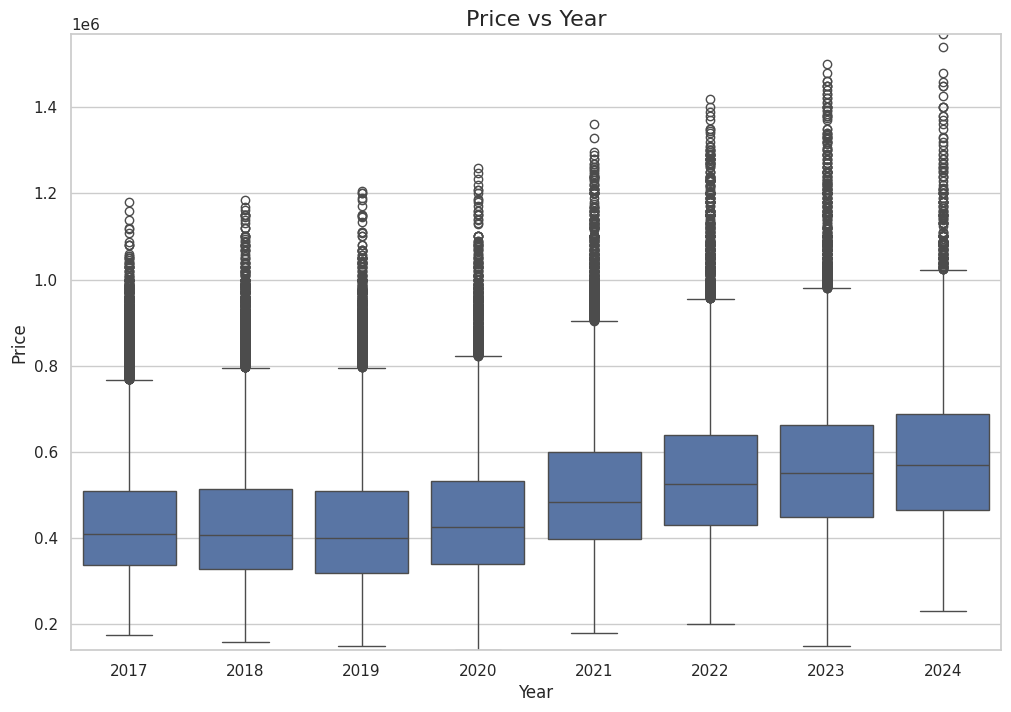

In [ ]:
df['year'] = df['year'].astype(str)
sns.set_theme(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(12, 8))  # Set the size of the plot
ax = sns.boxplot(x='year', y='resale_price', data=df)

# Set the title and labels
ax.set_title('Price vs Year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Price', fontsize=12)

plt.ylim(df['resale_price'].min(), df['resale_price'].max())

ax.legend().set_visible(False)
# Display the plot
plt.show()


The plot is a series of bar charts, each representing the average resale prices by town for different years. Each chart clearly displays variations in property values across towns, allowing for easy comparison of price for each town.

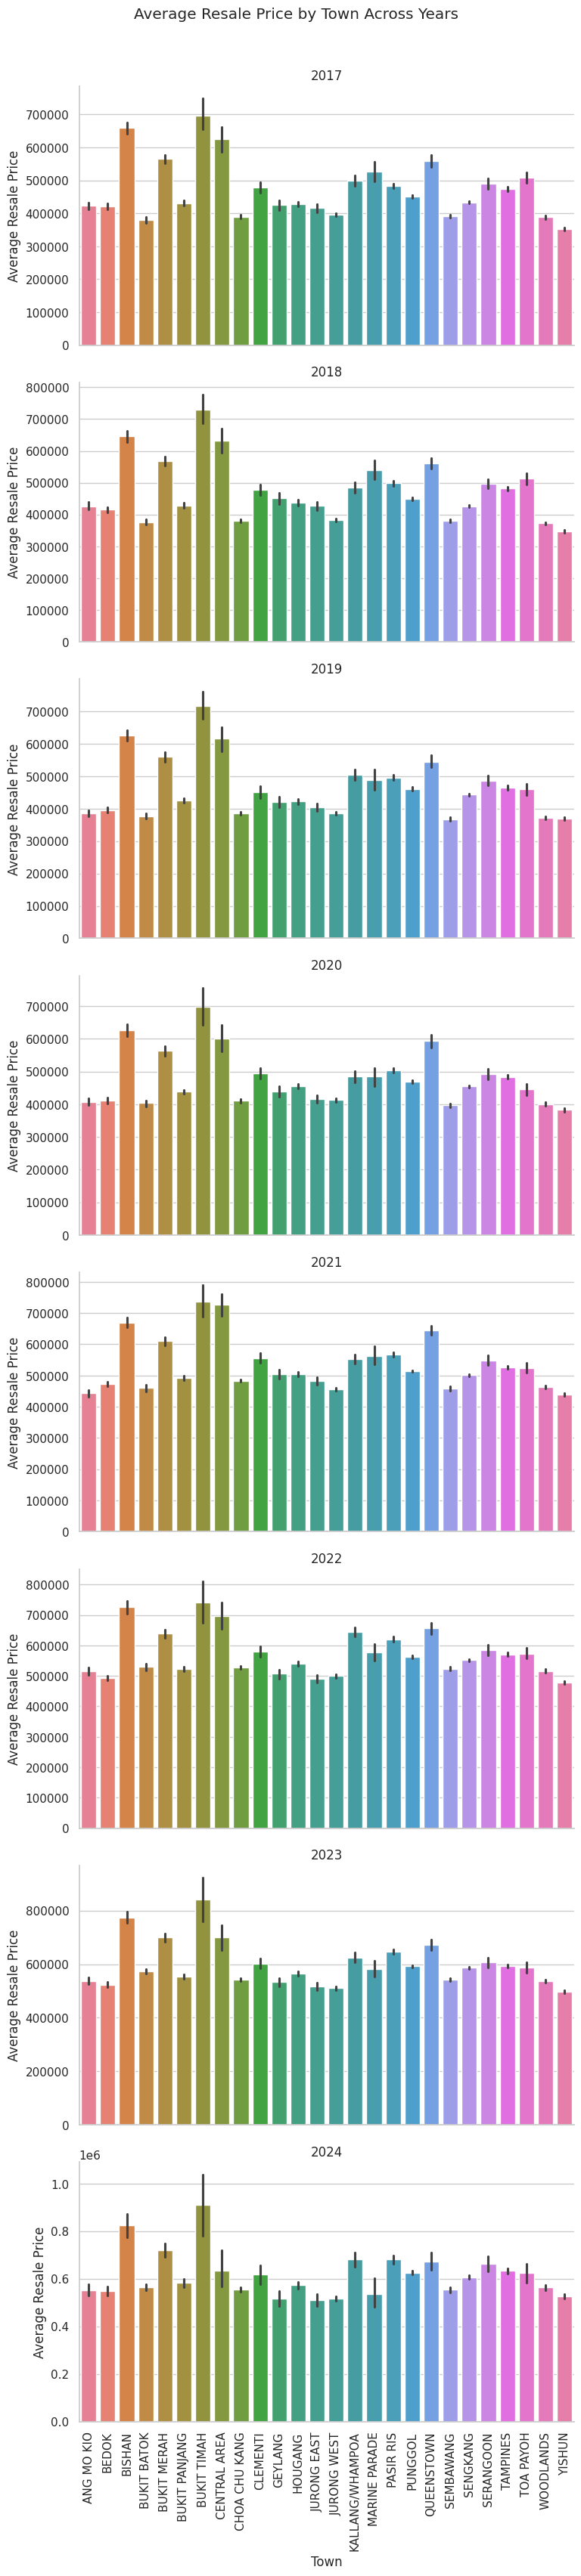

In [ ]:
g = sns.catplot(
    data=df,
    kind="bar",
    x="town",
    y="resale_price",
    hue="town",  # This will color the bars by town
    col="year",  # This creates a separate subplot for each year
    col_wrap=1,  # Each subplot will be in its own row
    sharey=False,  # Each subplot can have its own y-axis scale
    height=4,  # Height of each facet
    aspect=2,  # Aspect ratio of each facet, so each facet will be twice as wide as it is tall
)

# Set the titles and labels
g.fig.suptitle('Average Resale Price by Town Across Years', y=1.02)  # y=1.02 lifts the title slightly above the plots
g.set_axis_labels('Town', 'Average Resale Price')
g.set_titles('{col_name}')  # Set the title for each facet to the year

# Rotate the x-axis labels for better readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Display the plot
plt.show()

This line graph that displays the trends in average resale prices for different towns across various years, with each town represented by a unique line and marked data points. We can easily know the diffrent trend of each town.

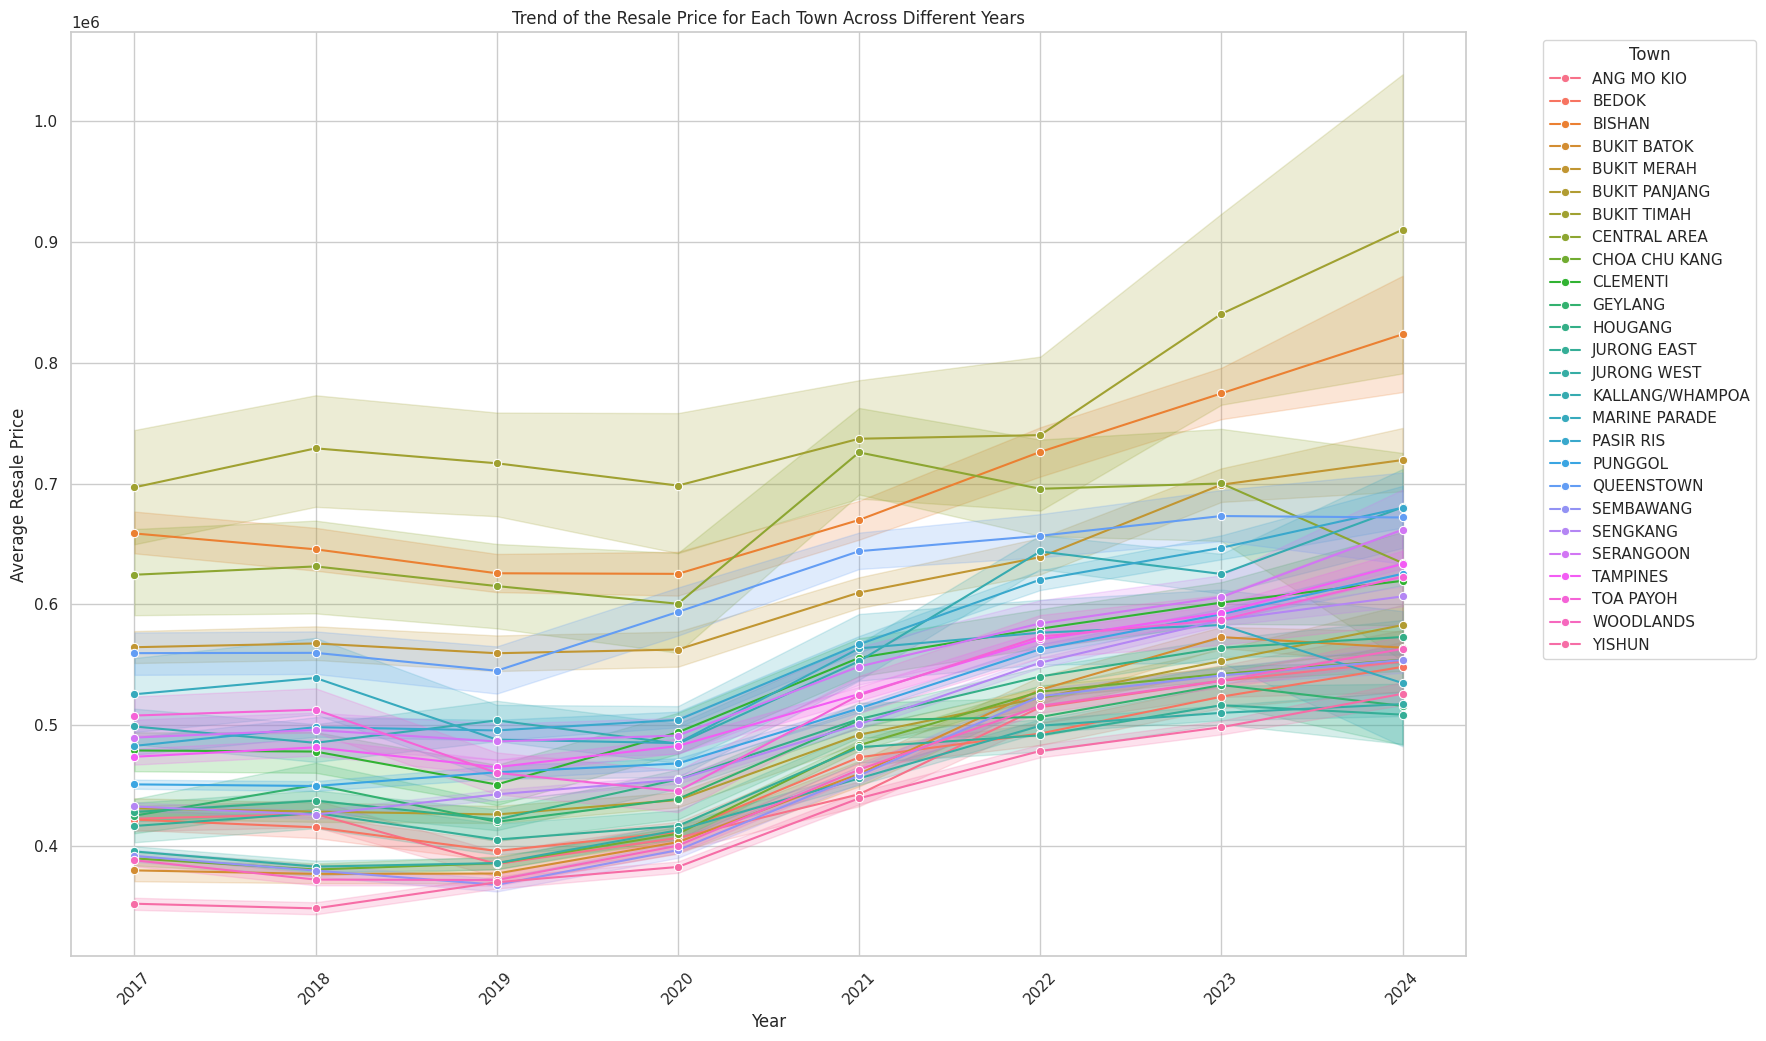

In [ ]:
plt.figure(figsize=(18, 12))  # Set the figure size

# Create the line plot
sns.lineplot(
    data=df,
    x="year",
    y="resale_price",
    hue="town",  # This will create a different line for each town
    marker="o",  # Mark each data point
)

# Label the axes and title
plt.title('Trend of the Resale Price for Each Town Across Different Years')
plt.xlabel('Year')
plt.ylabel('Average Resale Price')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Show the legend
plt.legend(title='Town', bbox_to_anchor=(1.05, 1), loc='upper left')


# Show the plot
plt.show()

The bar plot shows the average price of each price, which is reasonable. The larger the flat, the more higer the price.

<ipython-input-24-50294bb78365>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


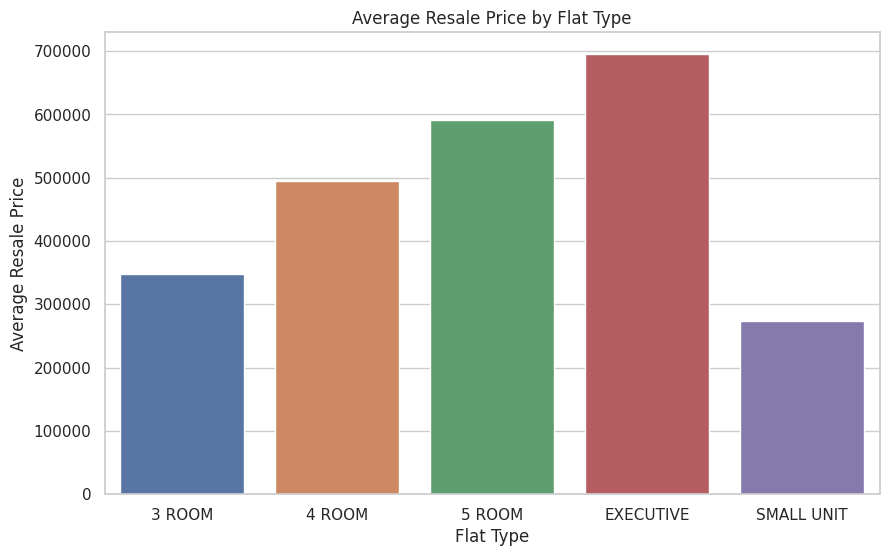

In [ ]:
average__by_type = df.groupby('flat_type')['resale_price'].mean().reset_index()

plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(
    data=average__by_type,
    x='flat_type',
    y='resale_price',
    palette='deep'  # This assigns different colors to each 'flat_type'
)

# Add the title and labels
plt.title('Average Resale Price by Flat Type')
plt.xlabel('Flat Type')
plt.ylabel('Average Resale Price')

# Show the plot
plt.show()

Same logic for storey range. The larger the storey, the more higer the price.

<ipython-input-25-1efa46aba2ff>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


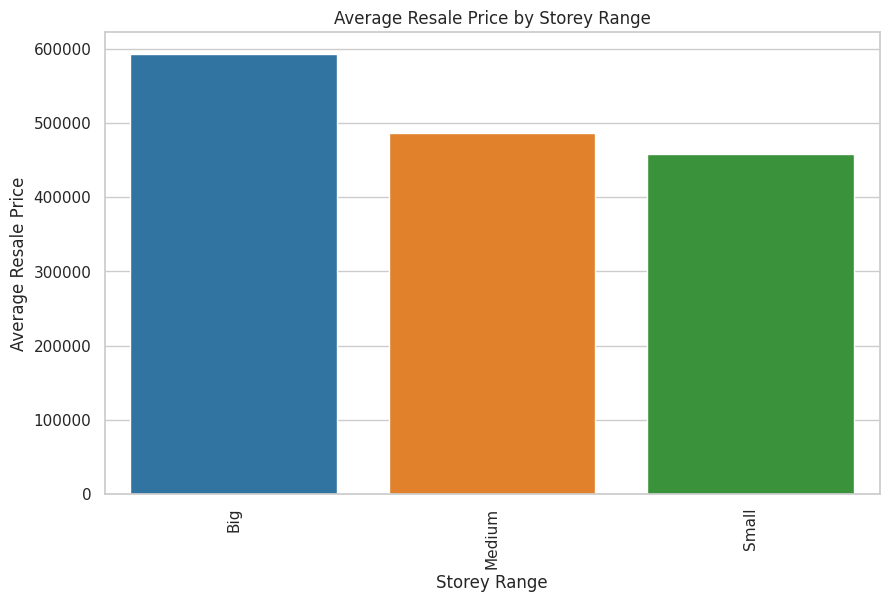

In [ ]:
average_storey_price = df.groupby('storey_range')['resale_price'].mean().reset_index()
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(
    data=average_storey_price,
    x='storey_range',  # Category column
    y='resale_price',  # Numeric column for average calculation
    palette='tab10',  # Color palette for the bars
    order=average_storey_price.sort_values('storey_range')['storey_range']  # Maintain original order
)

# Add the title and labels
plt.title('Average Resale Price by Storey Range')
plt.xlabel('Storey Range')
plt.ylabel('Average Resale Price')

# Optional: Rotate the x-axis labels if they overlap
plt.xticks(rotation=90)

# Show the plot
plt.show()

This plot shows average prices of each flat model, allowing us to compare between them.

<ipython-input-26-514751df88e6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


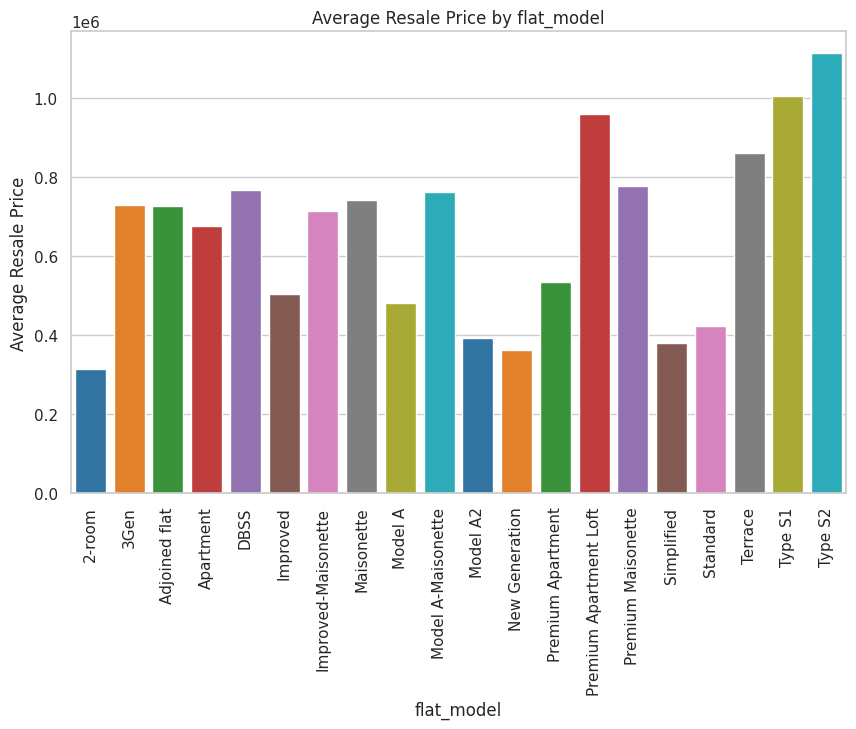

In [ ]:
average_fmodel_price = df.groupby('flat_model')['resale_price'].mean().reset_index()
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(
    data=average_fmodel_price,
    x='flat_model',  # Category column
    y='resale_price',  # Numeric column for average calculation
    palette='tab10',  # Color palette for the bars
    order=average_fmodel_price.sort_values('flat_model')['flat_model']  # Maintain original order
)

# Add the title and labels
plt.title('Average Resale Price by flat_model')
plt.xlabel('flat_model')
plt.ylabel('Average Resale Price')

# Optional: Rotate the x-axis labels if they overlap
plt.xticks(rotation=90)

# Show the plot
plt.show()

The boxplot allows us to understand the change in each month to see if ther is a seasonaly effect.

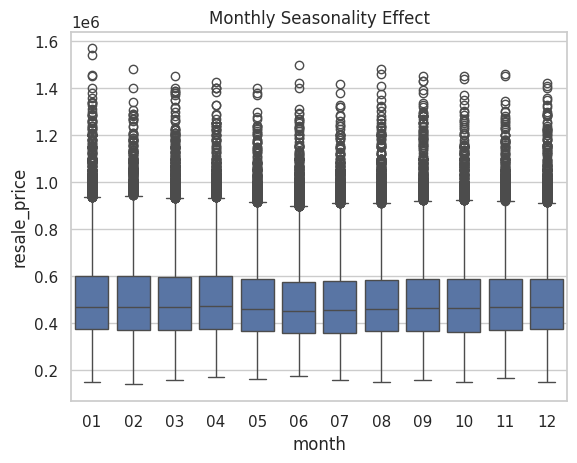

In [ ]:
sns.boxplot(data=df, x='month', y='resale_price')
plt.title('Monthly Seasonality Effect')
plt.show()

# 5. Modeling

## 5.1 Random Forest

### Model optimization

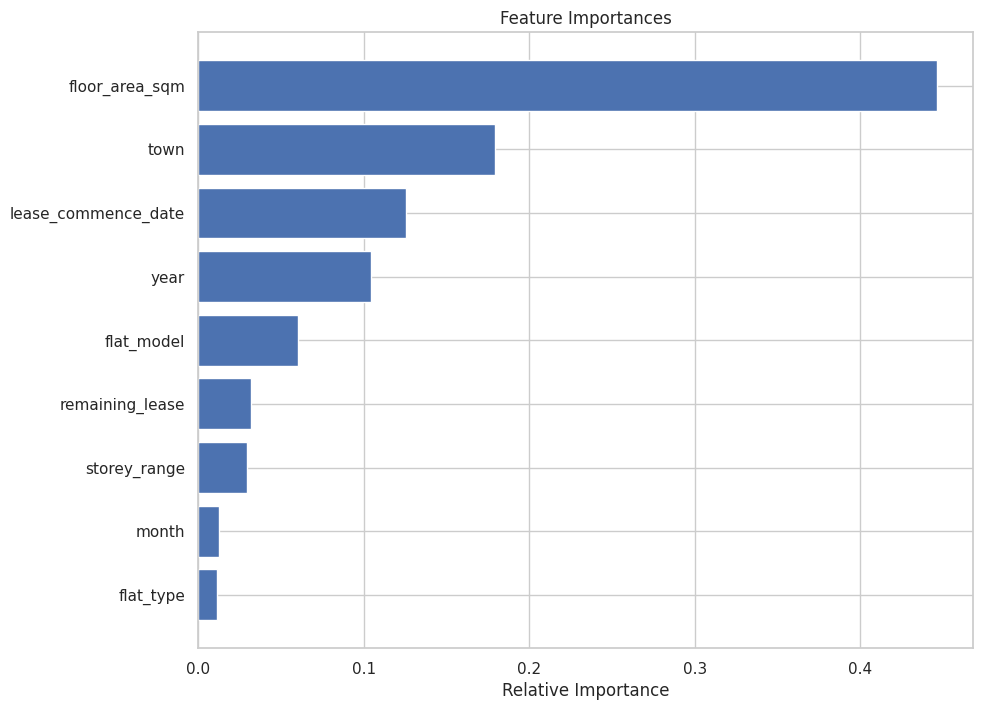

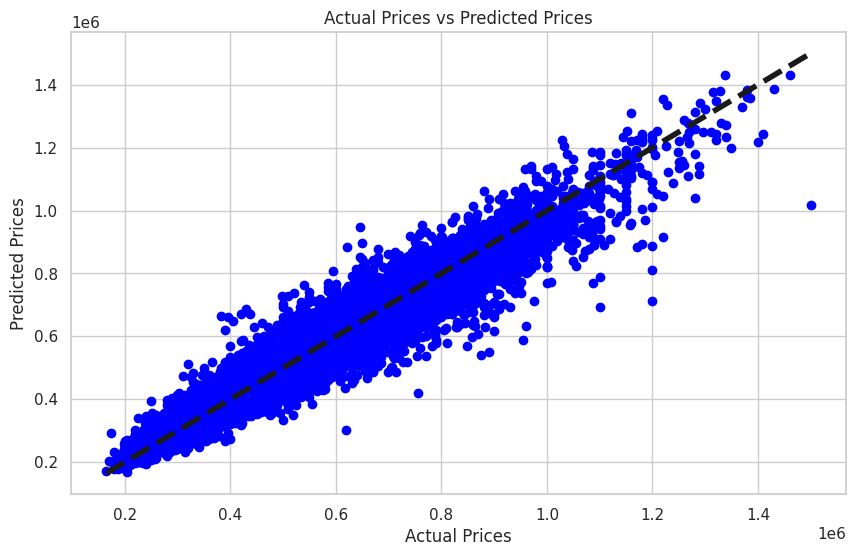

Mean Squared Error: 1453247794.471533
Root Mean Squared Error: 38121.48730665598
R^2 Score: 0.9509037575048523


In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


data = df_labelencoded
X = data.drop('resale_price', axis=1)
y = data['resale_price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest model
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
regressor.fit(X_train, y_train)

# Execute forecast
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Plotting feature importance for better visualization
features = X.columns
importances = regressor.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Results visualisation
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual Prices vs Predicted Prices')
plt.show()

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")


Model Evaluation: The performance of the model is evaluated using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² score. The computed MSE is 1453247794.47, RMSE is 38121.49, and the R² is 0.951, indicating high prediction accuracy and explanatory power of the model.

Feature Importance: A bar chart is plotted to show the importance of different features, helping understand which features have the most impact on predictions.

Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize the RandomizedSearchCV object
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", rf_random.best_params_)

# Use the best parameter model to predict
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Optimized Mean Squared Error:", mse)
print("Optimized R^2 Score:", r2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Optimized Mean Squared Error: 1428601933.1056898
Optimized R^2 Score: 0.9517363885198261


We use RandomizedSearchCV to optimize the parameters of a RandomForestRegressor to select the best model parameter configuration. This includes the number of trees, maximum tree depth, minimum samples required to split a node, minimum samples required at a leaf node, and whether to use bootstrap samples.

Feature Engineering

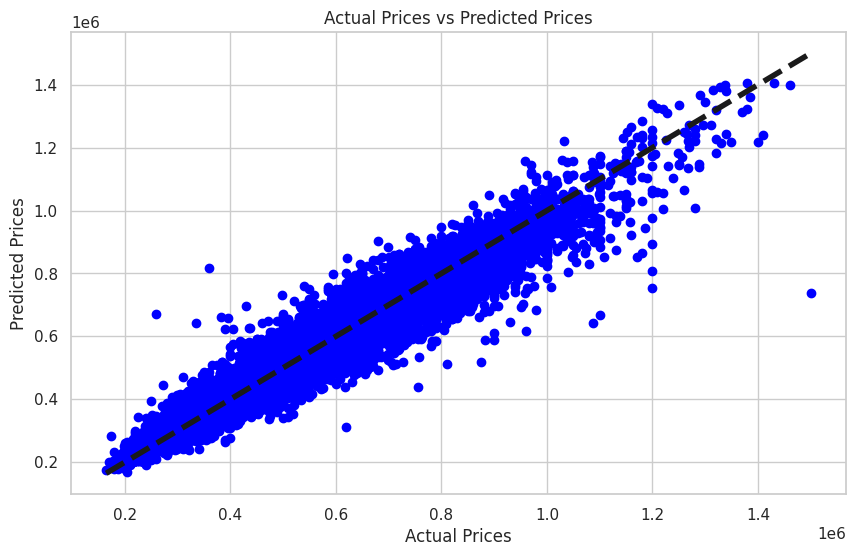

Mean Squared Error: 1409304742.0307062
Root Mean Squared Error: 37540.70779874437
R^2 Score: 0.9523883210918876


In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pandas as pd

# Load the data
data = df_labelencoded  # Ensure this is a DataFrame
X = data.drop('resale_price', axis=1)
y = data['resale_price']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Now X_poly is ready for model training

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Create a RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=500, min_samples_leaf=1, min_samples_split=5, random_state=42)

# Train the model
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual Prices vs Predicted Prices')
plt.show()

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")



Visualization: A scatter plot is generated to visually compare the actual and predicted prices. A diagonal line (k-dashed line) is also plotted to represent perfect predictions, aiding in visual assessment of the model's predictive accuracy.

This approach uses feature scaling and polynomial transformation to enhance the model's ability to capture complex relationships in the data. Training a RandomForestRegressor on this enhanced dataset and evaluating it using standard metrics and visualizations helps confirm the effectiveness of the model in predicting real estate prices.

### Conclusion for Random Forest

These steps demonstrate the robust capabilities of using RandomForest for regression analysis, especially when dealing with large datasets with complex relationships. Through appropriate feature engineering and parameter optimization, RandomForest models can not only deliver highly accurate predictions but also verify their stability and reliability through methods like cross-validation.

## 5.2 Time Series Analysis

In [ ]:
time_series.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month
date,,,,,,,,,,
2017-01-01,ANG MO KIO,SMALL UNIT,Medium,44.0,Improved,1979,61.333333,232000.0,2017,01
2017-01-01,ANG MO KIO,3 ROOM,Small,67.0,New Generation,1978,60.583333,250000.0,2017,01
2017-01-01,ANG MO KIO,3 ROOM,Small,67.0,New Generation,1980,62.416667,262000.0,2017,01
2017-01-01,ANG MO KIO,3 ROOM,Small,68.0,New Generation,1980,62.083333,265000.0,2017,01
2017-01-01,ANG MO KIO,3 ROOM,Small,67.0,New Generation,1980,62.416667,265000.0,2017,01


In [ ]:
time_series = time_series['resale_price']

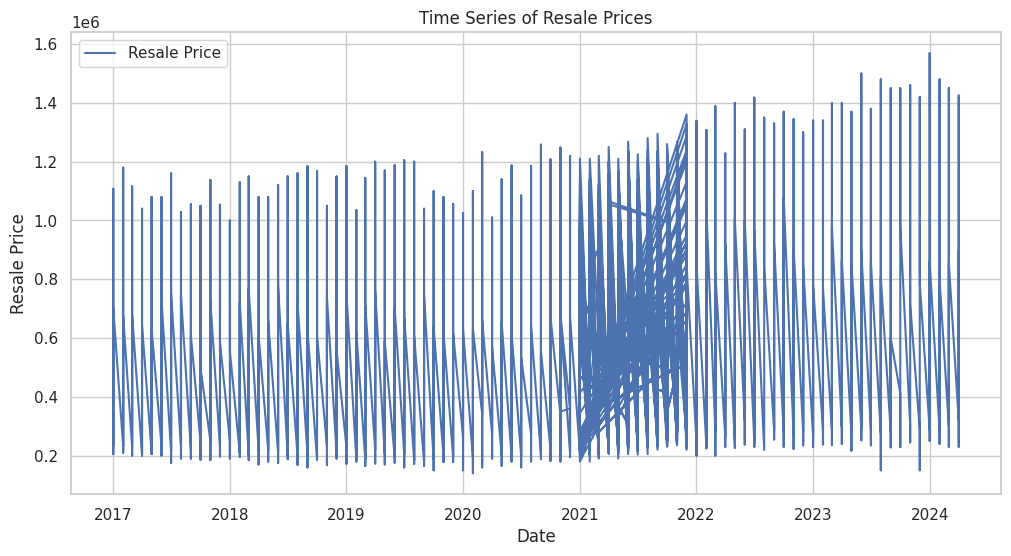

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Resale Price')
plt.title('Time Series of Resale Prices')
plt.xlabel('Date')
plt.ylabel('Resale Price')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

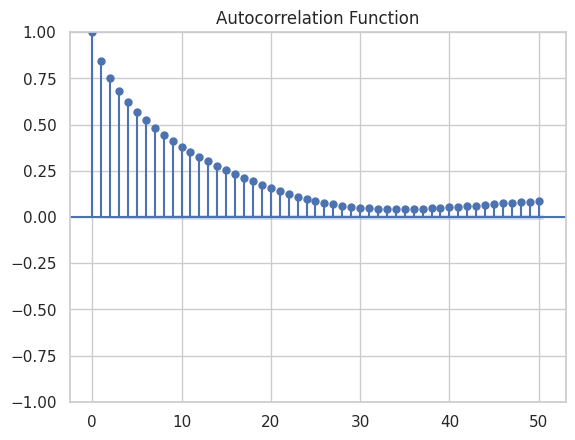

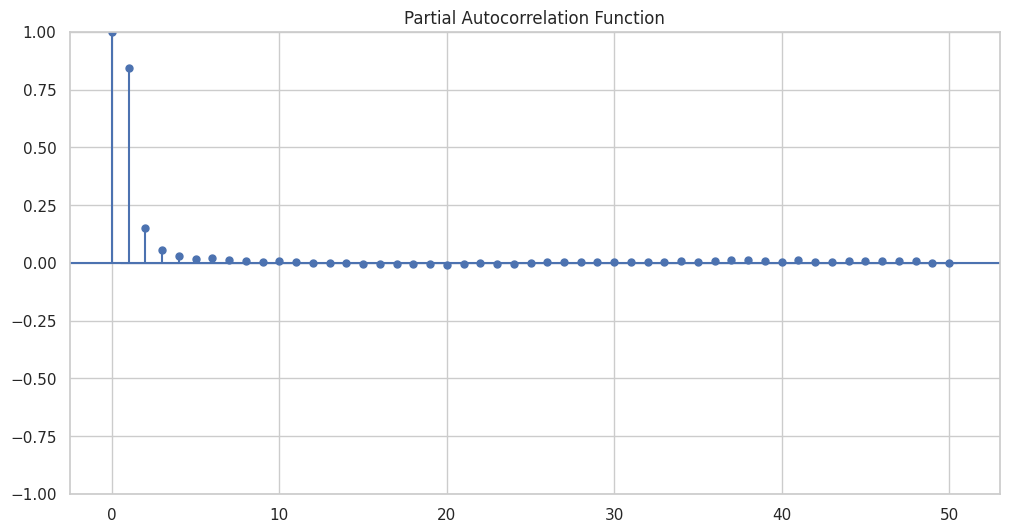

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(time_series, lags=50, alpha=0.05)
plt.title('Autocorrelation Function')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(time_series, lags=50, alpha=0.05, ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.show()

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

split_point = int(len(time_series) * 0.8)
train, test = time_series.iloc[:split_point], time_series.iloc[split_point:]

# Fit the ARIMA model on the training data
model = sm.tsa.arima.ARIMA(train, order=(1, 0, 0))
results = model.fit()

# Forecast the next steps equivalent to the test set size
forecasts = results.get_forecast(steps=len(test))
mean_forecast = forecasts.predicted_mean


# Calculate the confidence intervals for the forecasts
confidence_intervals = forecasts.conf_int()

# Calculate error metrics and r^2
mae = mean_absolute_error(test, mean_forecast)
rmse = np.sqrt(mean_squared_error(test, mean_forecast))
r_squared = r2_score(test, mean_forecast)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r_squared}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Mean Absolute Error: 149337.45873037836
Root Mean Squared Error: 201067.66775142477
R-squared: -0.3266712834703336


### Aggregate data for model

In [ ]:
df_time_median = time_series.groupby(time_series.index).median()

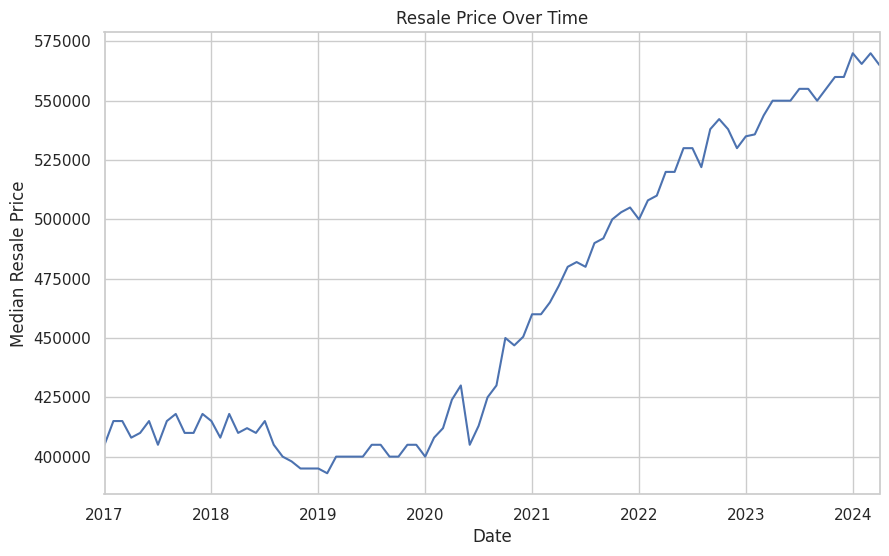

In [ ]:
df_time_median.plot(kind='line', figsize=(10, 6))

plt.title('Resale Price Over Time')
plt.xlabel('Date')
plt.ylabel('Median Resale Price')
plt.grid(True)
plt.show()

<Axes: xlabel='date'>

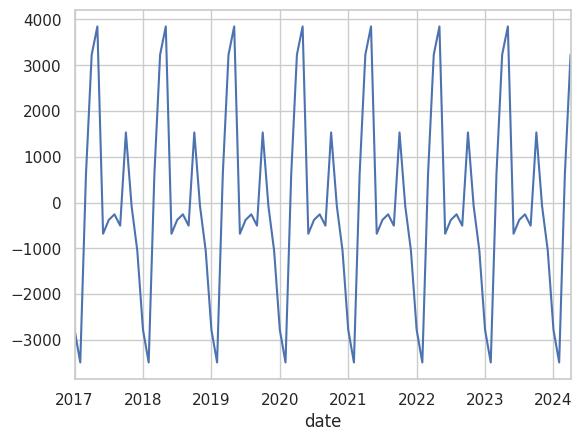

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_time_median, model='additive', period=12)
decomposition.seasonal.plot()

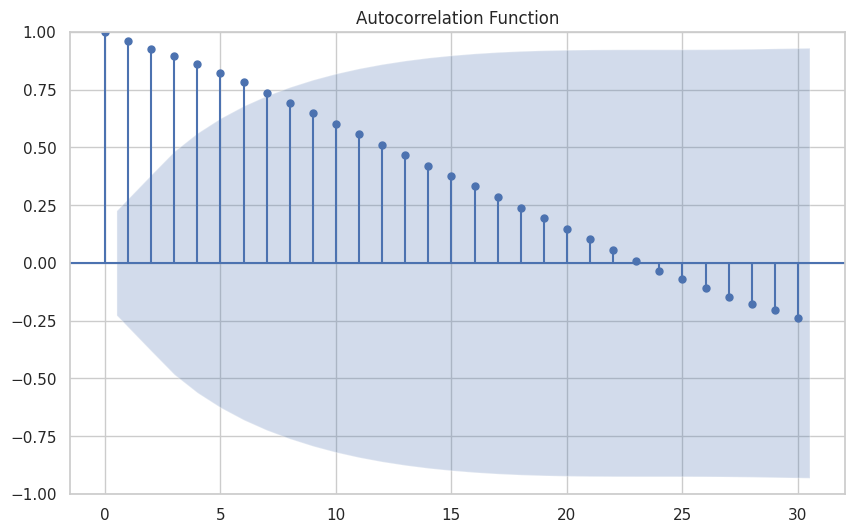

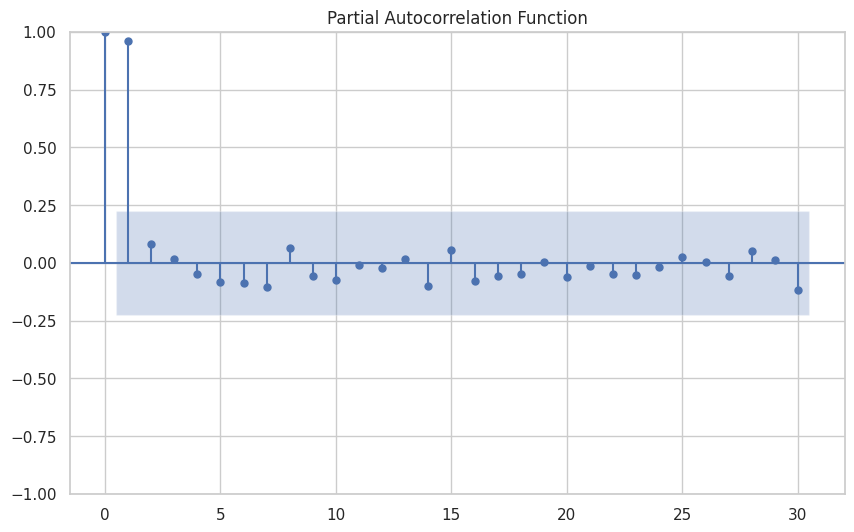

In [ ]:
# split into train test data set
train_resale = df_time_median[df_time_median.index <= '2023-03-31']
test_resale = df_time_median[df_time_median.index > '2023-03-31']

# Plot the ACF
plt.figure(figsize=(10, 6))
plot_acf(train_resale, lags=30, ax=plt.gca())
plt.title('Autocorrelation Function')
plt.show()

# Plot the PACF
plt.figure(figsize=(10, 6))
plot_pacf(train_resale, lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.show()

ARIMA Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. 

                               SARIMAX Results                                
Dep. Variable:           resale_price   No. Observations:                   75
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -752.153
Date:                Fri, 26 Apr 2024   AIC                           1524.307
Time:                        10:59:31   BIC                           1547.348
Sample:                    01-01-2017   HQIC                          1533.498
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6939      1.097     -0.632      0.527      -2.845       1.457
ar.L2          0.0380      0.269      0.142      0.887      -0.488       0.565
ar.L3          0.7786      0.198      3.927      0.0

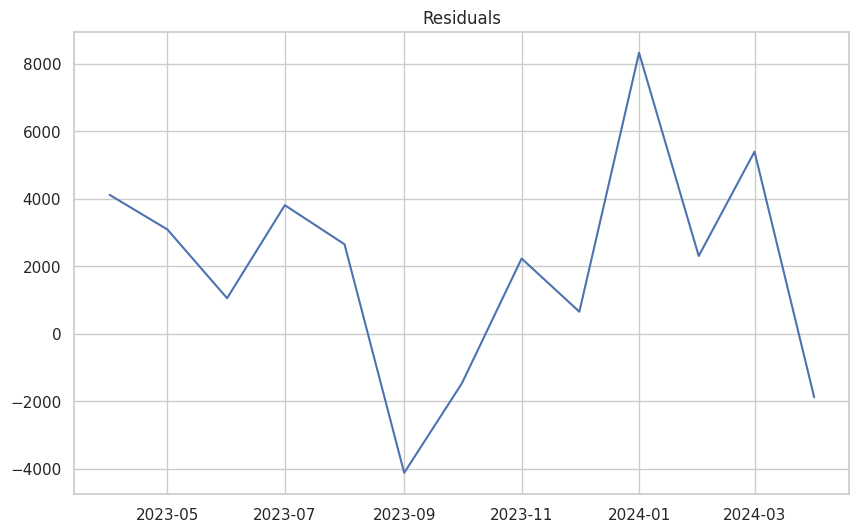

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_resale, order=(5,1,4))
results = model.fit()

# Summary of the model
print(results.summary())

# Forecasting
forecast = results.forecast(steps=len(test_resale))

y_true = test_resale
forecast.index = y_true.index

mae = mean_absolute_error(y_true, forecast)
rmse = np.sqrt(mean_squared_error(y_true, forecast))
r_squared = r2_score(y_true, forecast)
print(f'MAE: {mae}, RMSE: {rmse}, r^2: {r_squared}')

# Residual analysis
residuals = y_true - forecast
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

In [ ]:
def time_series_cross_validation(data, order, min_test_size, max_test_size):

    tscv_rmse = []
    tscv_true = []
    tscv_pred = []
    tscv_mae = []
    tscv_r2 = []

    for test_size in range(min_test_size, min(max_test_size + 1, len(data))):
        # Split the data into training and testing sets
        train = data.iloc[:-test_size]
        test = data.iloc[-test_size:]

        # Fit the SARIMA model
        model = ARIMA(train, order=order)
        results = model.fit()

        # Forecasting
        forecast = results.get_forecast(steps=len(test))
        predicted_mean = forecast.predicted_mean

        # Calculate RMSE and MAE
        mae = mean_absolute_error(test, predicted_mean)
        rmse = np.sqrt(mean_squared_error(test, predicted_mean))
        r_squared = r2_score(test, predicted_mean)  # Calculate R^2

        # Store metrics and values
        tscv_rmse.append(rmse)
        tscv_mae.append(mae)
        tscv_r2.append(r_squared)
        tscv_true.append(test)
        tscv_pred.append(predicted_mean)

    return tscv_rmse, tscv_mae, tscv_r2, tscv_true, tscv_pred

# Example usage:
order = (5,1,4)
min_test_size = 6
max_test_size = 18
rmse_values, mae_values, r2_values, true_values, pred_values = time_series_cross_validation(df_time_median, order, min_test_size, max_test_size)

print("MAE values for each split:", mae_values)
print("Average MAE:", np.mean(mae_values))
print("RMSE values for each split:", rmse_values)
print("Average RMSE:", np.mean(rmse_values))
print("R^2 values for each split:", r2_values)
print("Average R^2:", np.mean(r2_values))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

MAE values for each split: [3776.318221493857, 7401.9747165596345, 3254.833255466365, 3012.492601738415, 2979.0858877252786, 2582.57975780258, 2356.365440199928, 3159.3483087911377, 7289.864930790201, 7371.603853126561, 11050.082831414904, 3504.4959391282378, 7829.3451721445435]
Average MAE: 5043.722378183204
RMSE values for each split: [4942.329479944146, 8275.364344530344, 4145.804170256918, 3958.1895295711256, 3791.965951552818, 3503.2349094263527, 3302.421524348595, 3728.2234940255394, 7899.6517760781, 8176.74170774975, 11821.114477865875, 4546.7663527327295, 8784.742688743198]
Average RMSE: 5913.580800525037
R^2 values for each split: [-0.46255026158785717, -1.5585978625249588, 0.6073838486804113, 0.6412076865952713, 0.6634324822345166, 0.744517637074333, 0.7864115791880251, 0.7358550633962357, 0.0008077950126008648, 0.22707984431271855, -0.31657884816187853, 0.8443348631086284, 0.4373155449424746]
Average R^2: 0.2577399517131169


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       resale_price   No. Observations:                   75
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -636.654
Date:                            Fri, 26 Apr 2024   AIC                           1279.308
Time:                                    10:59:40   BIC                           1285.690
Sample:                                01-01-2017   HQIC                          1281.814
                                     - 03-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0047      0.002    510.530      0.000       1.001       1.009
ar.S.L12       0.0167      0.178   

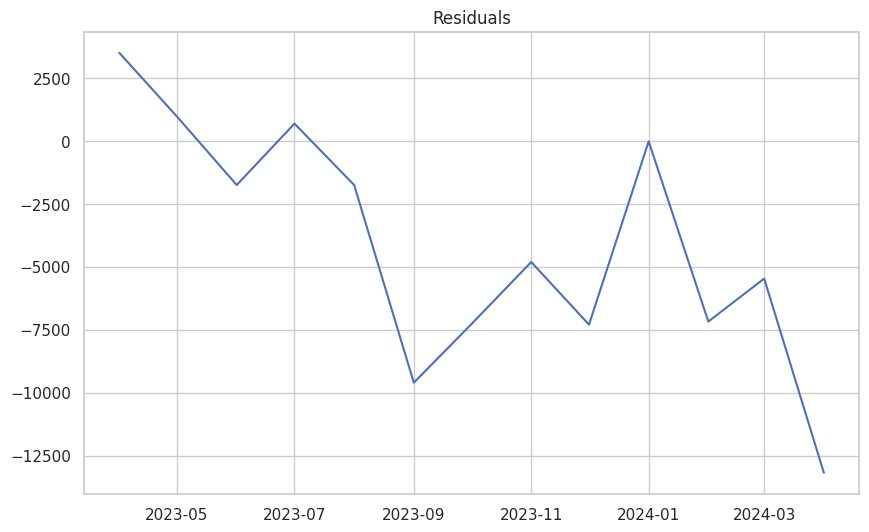

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = 1, 0, 0

seasonal_order = 1, 0, 0, 12

# Fit the SARIMA model
sarima_model = SARIMAX(train_resale,
                       order=order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

results = sarima_model.fit()

# Summarize model
print(results.summary())

forecast_steps = len(test_resale)  # Forecasting
forecast = results.get_forecast(steps=forecast_steps)
predicted_mean = forecast.predicted_mean


test_mae = mean_absolute_error(test_resale, predicted_mean)
test_rmse = np.sqrt(mean_squared_error(test_resale, predicted_mean))
test_r_squared = r2_score(test_resale, predicted_mean)
print(f'Test MAE: {test_mae}, Test RMSE: {test_rmse}, Test r^2: {test_r_squared}')

# Residual analysis
residuals = test_resale - predicted_mean
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

In [ ]:
def time_series_cross_validation(data, order, seasonal_order, min_test_size, max_test_size):

    tscv_rmse = []
    tscv_true = []
    tscv_pred = []
    tscv_mae = []
    tscv_r2 = []

    for test_size in range(min_test_size, min(max_test_size + 1, len(data))):
        # Split the data into training and testing sets
        train = data.iloc[:-test_size]
        test = data.iloc[-test_size:]

        # Fit the SARIMA model
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # Forecasting
        forecast = results.get_forecast(steps=len(test))
        predicted_mean = forecast.predicted_mean

        # Calculate RMSE, MAE, and R^2
        mae = mean_absolute_error(test, predicted_mean)
        rmse = np.sqrt(mean_squared_error(test, predicted_mean))
        r_squared = r2_score(test, predicted_mean)

        tscv_rmse.append(rmse)
        tscv_mae.append(mae)
        tscv_r2.append(r_squared)

        # Store true and predicted values
        tscv_true.append(test)
        tscv_pred.append(predicted_mean)

    return tscv_rmse, tscv_mae, tscv_r2, tscv_true, tscv_pred


order = (1,0,0)
seasonal_order = (1, 0, 0, 12)
min_test_size = 7
max_test_size = 17
rmse_values, mae_values, r2_values, true_values, pred_values = time_series_cross_validation(df_time_median, order, seasonal_order, min_test_size, max_test_size)

print("MAE values for each split:", mae_values)
print("Average MAE:", np.mean(mae_values))
print("RMSE values for each split:", rmse_values)
print("Average RMSE:", np.mean(rmse_values))
print("R^2 values for each split:", r2_values)
print("Average R^2:", np.mean(r2_values))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

MAE values for each split: [4511.14143976807, 5448.830433731957, 7056.260136423439, 4498.572455806076, 6392.356437478151, 8865.386566409725, 4879.953826889494, 4178.643714958802, 3575.365785939914, 4606.880712497848, 9619.22773069876]
Average MAE: 5784.783567327477
RMSE values for each split: [5232.426576868737, 6114.1478230845205, 7989.1714834830045, 5375.773292297307, 7610.616859523222, 9940.916161661513, 6175.94514783336, 5014.1688677263255, 4201.261917408219, 5490.354222776626, 10670.090957524824]
Average RMSE: 6710.443028198878
R^2 values for each split: [-0.022902101588861967, 0.14606962414138747, -0.4616838395228555, 0.32356630604068026, -0.20576346957033143, -0.9353767277791796, 0.27515479126629416, 0.5974395969438479, 0.7959514142159647, 0.7159918800321204, 0.14272072189868001]
Average R^2: 0.12465165418888603


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Conclusion for Time Series Ananlysis

We have experimented 3 different time series analysis. For all the models, we first plotted the ACF, PACF and seasonal decomposition to understand the dataset. The first one use the entire dataset, which performs quite bad. Since there are lots of datapoints in one single day (a month).

So the data was aggreagted into monthly median. We used median to avoid influence of outliers. The fitted the aggregated data into 2 models, ARIMA and SARIMA.

Based on the results of ACF and PACF plots, we started with simple ARIMA with small, (p, d, q). However, when we increased the order value to (5,1,4),
the performance is better than all other combination we tried. A cross valation is ran and indicating a robust performance of ARIMA.

We did find an insight of seasonal pattern from the above plots. Unfornately, the SARIMA did not perform better than ARIMA model even if we have tried lots of combinations of parameters and the recommended paramenter by ACF and PACF. One possible reason is that, there are much more parameters for tuning in SARIMA, (pdq) (PDQS)

###Final comparison:

####ARIMA (whole dataset):

Mean Absolute Error: 149337.4587303785

Root Mean Squared Error: 201067.66775142497

R-squared: -0.32667128347033625

####ARIMA (aggregated dataset, averaging of cross validation):

Average MAE: 5020.353665947009

Average RMSE: 5870.668152945862

Average R^2: 0.27045469997772414

####SARIMA (aggregated dataset, averaging of cross validation):

Average MAE: 5784.783552150794

Average RMSE: 6710.4430131569625

Average R^2: 0.12465165904763978

Based on the aboe error parameters, the best performed time series model is ARIMA.

## 5.3 Xgboost + Bagging

In [ ]:
# one-hot encoding for town and year in columns
df_onehot = pd.get_dummies(df_labelencoded, columns=['town', 'year'])
df_onehot.head()

,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,month,town_0,town_1,...,town_24,town_25,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
0,4,1,44.0,5,1979,235,232000.0,1,True,False,...,False,False,True,False,False,False,False,False,False,False
1,0,2,67.0,11,1978,226,250000.0,1,True,False,...,False,False,True,False,False,False,False,False,False,False
2,0,2,67.0,11,1980,248,262000.0,1,True,False,...,False,False,True,False,False,False,False,False,False,False
3,0,2,68.0,11,1980,244,265000.0,1,True,False,...,False,False,True,False,False,False,False,False,False,False
4,0,2,67.0,11,1980,248,265000.0,1,True,False,...,False,False,True,False,False,False,False,False,False,False


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression

df = df_onehot

# Fit a linear regression model to get feature importance
X = df.drop('resale_price', axis=1)
y = df['resale_price']
model = LinearRegression()
model.fit(X, y)

# Get feature importance from the coefficients
feature_importance = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
# print("Feature Importances from Linear Regression:")
# print(feature_importance.sort_values(by='Coefficient', ascending=False))

# Optional: Using sklearn to get F-statistics and p-values
f_scores, p_values = f_regression(X, y)
# print("\nF-scores and p-values:")
display(pd.DataFrame({'Feature': X.columns, 'F-score': f_scores, 'p-value': p_values}))

,Feature,F-score,p-value
0,flat_type,50057.564568,0.000000e+00
1,storey_range,13683.070481,0.000000e+00
2,floor_area_sqm,99870.626401,0.000000e+00
3,flat_model,10362.165599,0.000000e+00
4,lease_commence_date,27518.211562,0.000000e+00
5,remaining_lease,20932.765209,0.000000e+00
6,month,22.005549,2.720655e-06
7,town_0,466.752041,2.219429e-103
8,town_1,564.120175,1.672691e-124
9,town_2,3823.962505,0.000000e+00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Four features plus the target
features = X  # Replace with your actual feature names
target = df['resale_price']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Linear Regression MSE: 4422662370.403778
Linear Regression R^2: 0.8505856296238391


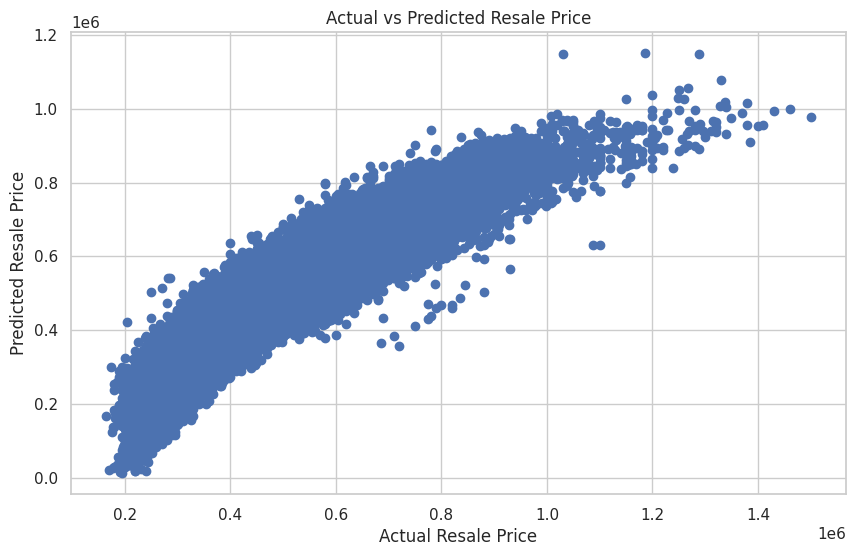

In [ ]:
## Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predicting and evaluating the model
y_pred = linear_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression MSE: {mse}")
print(f"Linear Regression R^2: {r2}")

# plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('Actual vs Predicted Resale Price')
plt.grid(True)
plt.show()

In [ ]:
## XGBoost Modeling
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Define the parameter sets: set 1
parameter_sets = [
    {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'alpha': 5},
    {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'alpha': 10},
    {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'alpha': 0},
    {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50, 'alpha': 20},
    {'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 250, 'alpha': 15}
]

# Results dictionary to store MSE and R^2 for each parameter set
results = []

# Train a model for each set of parameters
for params in parameter_sets:
    xgb_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                 colsample_bytree = 0.3,
                                 learning_rate = params['learning_rate'],
                                 max_depth = params['max_depth'],
                                 alpha = params['alpha'],
                                 n_estimators = params['n_estimators'])

    xgb_model.fit(X_train_scaled, y_train)
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)

    results.append({
        'params': params,
        'RMSE': rmse_xgb,
        'R2': r2_xgb
    })

# Print the results
for result in results:
    print(f"Parameters: {result['params']}")
    print(f"RMSE: {result['RMSE']}")
    print(f"R2: {result['R2']}\n")


Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'alpha': 5}
RMSE: 88367.02344567077
R2: 0.7361913474099415

Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'alpha': 10}
RMSE: 51876.539514112665
R2: 0.9090818522626383

Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'alpha': 0}
RMSE: 39478.695543894275
R2: 0.9473456602533754

Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50, 'alpha': 20}
RMSE: 145243.95965086328
R2: 0.2873033077638816

Parameters: {'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 250, 'alpha': 15}
RMSE: 35662.74754688422
R2: 0.9570326884048392



In [ ]:
# Define the refined parameter sets: set 2
refined_parameter_sets = [
    {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'alpha': 10},
    {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'alpha': 0},
    {'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 250, 'alpha': 15},
    {'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 160, 'alpha': 10},
    {'learning_rate': 0.18, 'max_depth': 6, 'n_estimators': 220, 'alpha': 5}
]

# Lists to store results for plotting
learning_rates = []
rmses = []

# Train a model for each set of refined parameters
for params in refined_parameter_sets:
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=0.3,
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        alpha=params['alpha'],
        n_estimators=params['n_estimators']
    )

    xgb_model.fit(X_train_scaled, y_train)
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

    # Append results to lists
    learning_rates.append(params['learning_rate'])
    rmses.append(rmse_xgb)

    print(f"Parameters: {params}")
    print(f"RMSE: {rmse_xgb}")
    print(f"R2: {r2_xgb}\n")


Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'alpha': 10}
RMSE: 51876.539514112665
R2: 0.9570326884048392

Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'alpha': 0}
RMSE: 39478.695543894275
R2: 0.9570326884048392

Parameters: {'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 250, 'alpha': 15}
RMSE: 35662.74754688422
R2: 0.9570326884048392

Parameters: {'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 160, 'alpha': 10}
RMSE: 54681.98556403451
R2: 0.9570326884048392

Parameters: {'learning_rate': 0.18, 'max_depth': 6, 'n_estimators': 220, 'alpha': 5}
RMSE: 37221.27018277873
R2: 0.9570326884048392



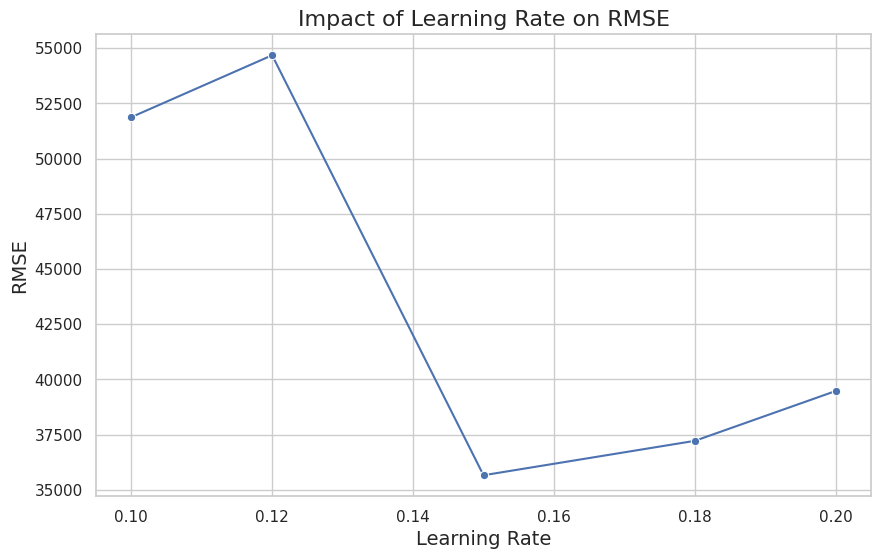

In [ ]:
# Create a DataFrame from the collected data
data = pd.DataFrame({
    'Learning Rate': learning_rates,
    'RMSE': rmses
})

# Plotting
plt.figure(figsize=(10, 6))  # Larger figure size for better visibility
sns.lineplot(x='Learning Rate', y='RMSE', data=data, marker='o')
plt.title('Impact of Learning Rate on RMSE', fontsize=16)
plt.xlabel('Learning Rate', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.grid(True)
plt.show()


Description: This plot demonstrates the relationship between the learning rate and RMSE, providing insights into how tuning this parameter can minimize prediction errors, thus optimizing model performance.

In [ ]:
# Final Tuning
import numpy as np
import xgboost as xgb
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the new parameter sets
new_parameter_sets = [
    {'learning_rate': 0.13, 'max_depth': 8, 'n_estimators': 310, 'alpha': 3},
    {'learning_rate': 0.11, 'max_depth': 9, 'n_estimators': 250, 'alpha': 10},
    {'learning_rate': 0.19, 'max_depth': 7, 'n_estimators': 230, 'alpha': 15},
    {'learning_rate': 0.12, 'max_depth': 8, 'n_estimators': 320, 'alpha': 0},
    {'learning_rate': 0.14, 'max_depth': 6, 'n_estimators': 270, 'alpha': 5}
]


ls_rmse = []

# Train a bagged model for each set of parameters
for params in new_parameter_sets:
    base_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=0.3,
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        alpha=params['alpha'],
        n_estimators=params['n_estimators']
    )

    bagged_model = BaggingRegressor(base_estimator=base_model, n_estimators=10, random_state=42)
    bagged_model.fit(X_train_scaled, y_train)
    y_pred_bagged = bagged_model.predict(X_test_scaled)
    rmse_bagged = np.sqrt(mean_squared_error(y_test, y_pred_bagged))
    r2_bagged = r2_score(y_test, y_pred_bagged)

    ls_rmse.append(rmse_bagged)

    print(f"Parameters: {params}")
    print(f"Bagged XGBoost RMSE: {rmse_bagged}")
    print(f"Bagged XGBoost R2: {r2_bagged}\n")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Parameters: {'learning_rate': 0.13, 'max_depth': 8, 'n_estimators': 310, 'alpha': 3}
Bagged XGBoost RMSE: 34052.42755836954
Bagged XGBoost R2: 0.9608253848893495



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Parameters: {'learning_rate': 0.11, 'max_depth': 9, 'n_estimators': 250, 'alpha': 10}
Bagged XGBoost RMSE: 34239.658372603604
Bagged XGBoost R2: 0.9603934122033057



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Parameters: {'learning_rate': 0.19, 'max_depth': 7, 'n_estimators': 230, 'alpha': 15}
Bagged XGBoost RMSE: 34858.496801681984
Bagged XGBoost R2: 0.9589487965703483



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Parameters: {'learning_rate': 0.12, 'max_depth': 8, 'n_estimators': 320, 'alpha': 0}
Bagged XGBoost RMSE: 34118.179949524114
Bagged XGBoost R2: 0.9606739530149156



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Parameters: {'learning_rate': 0.14, 'max_depth': 6, 'n_estimators': 270, 'alpha': 5}
Bagged XGBoost RMSE: 36674.32865730091
Bagged XGBoost R2: 0.9545605644390649



### Model Optimization and Performance Analysis

**Optimizing XGBoost with Bagging**

We adopted an advanced ensemble method combining XGBoost with a Bagging Regressor to enhance the predictive stability and accuracy of our housing price prediction model. This integration aims to reduce variance, prevent overfitting, and improve the model's generalization capabilities across diverse datasets.

**Parameter Tuning Strategy**:
To fine-tune our model, we conducted extensive hyperparameter optimization. We iteratively adjusted parameters such as learning rate, max depth, n_estimators, and regularization term alpha. The best-performing parameters from the final iteration were:
- Learning Rate: 0.13
- Max Depth: 8
- N Estimators: 310
- Alpha: 3

These parameters were selected based on their ability to minimize the Root Mean Squared Error (RMSE) while maximizing the R² metric, indicative of the model's accuracy and fit.



**Visualizations**:
- **Feature Importance Plot**: Showcasing the relative importance of each feature in the dataset, providing insights into which factors most significantly influence housing prices.


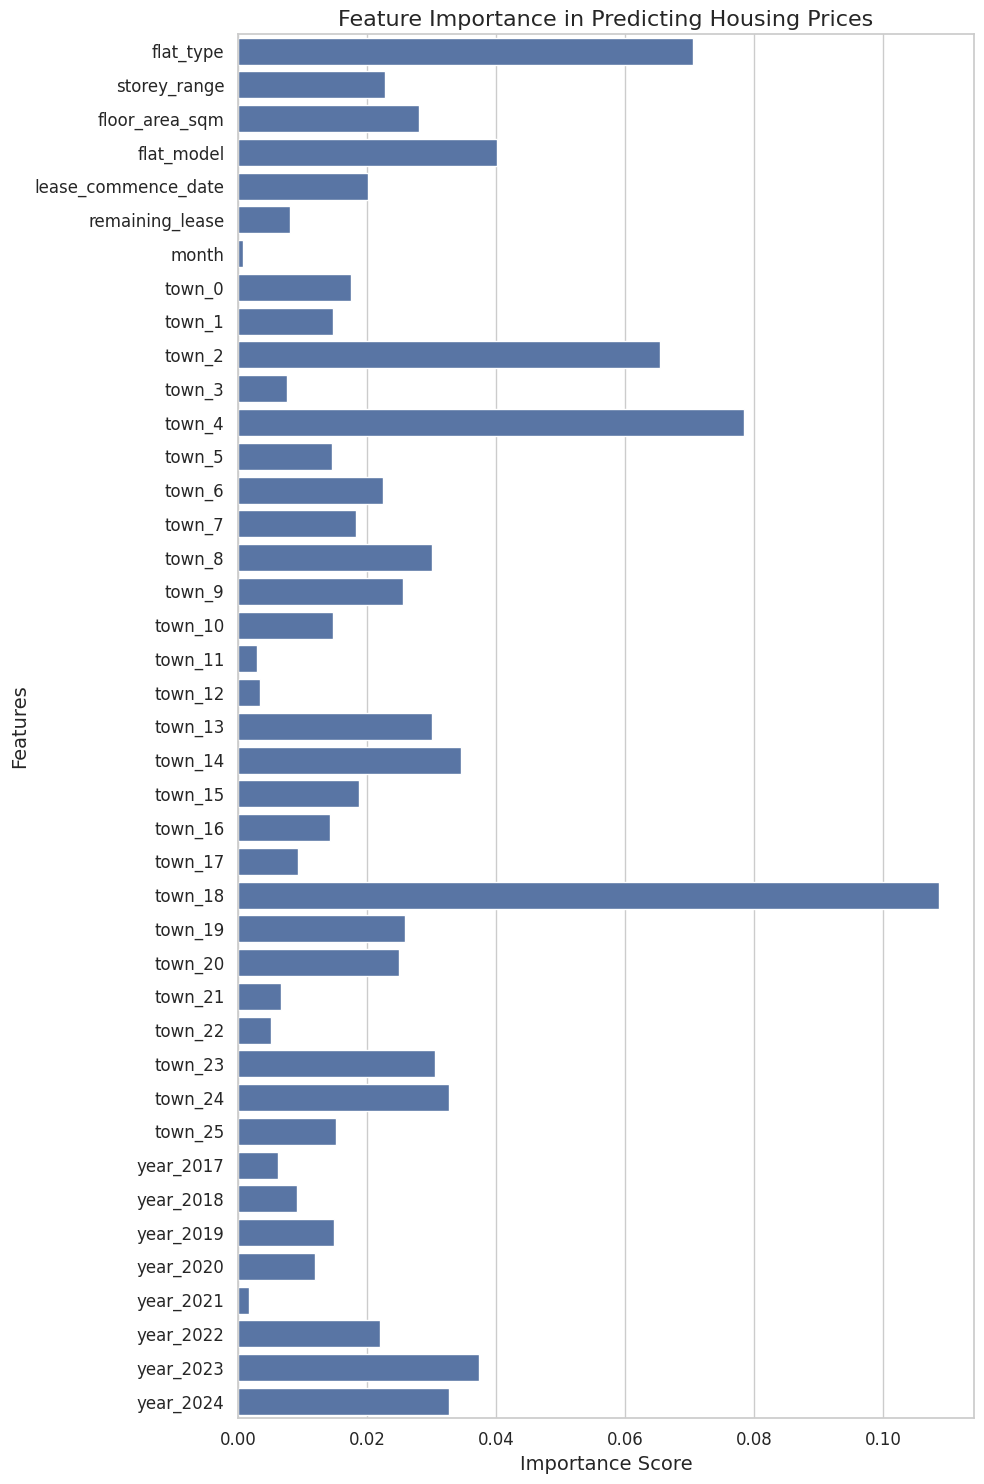

In [ ]:
# Feature Importance Plot:
# Showcasing the relative importance of each feature in the dataset, providing insights into which factors most significantly influence housing prices.

feature_importances = xgb_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 15))  # Set the figure size appropriately
sns.barplot(x=feature_importances, y=features, orient='h')  # 'h' for horizontal bar plots
plt.title('Feature Importance in Predicting Housing Prices', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)  # Adjust font size for x-ticks
plt.yticks(fontsize=12)  # Adjust font size for y-ticks
plt.tight_layout()  # Automatically adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.show()



Description: The feature importance plot reveals which variables most significantly influence the prediction of housing prices, helping to understand the data's dynamics and guide further data collection and feature engineering efforts.

- **Predictive Accuracy Plot**: Comparing actual vs. predicted prices on the test set, this plot visually underscores the model's predictive power and areas where it may under or overestimate values.


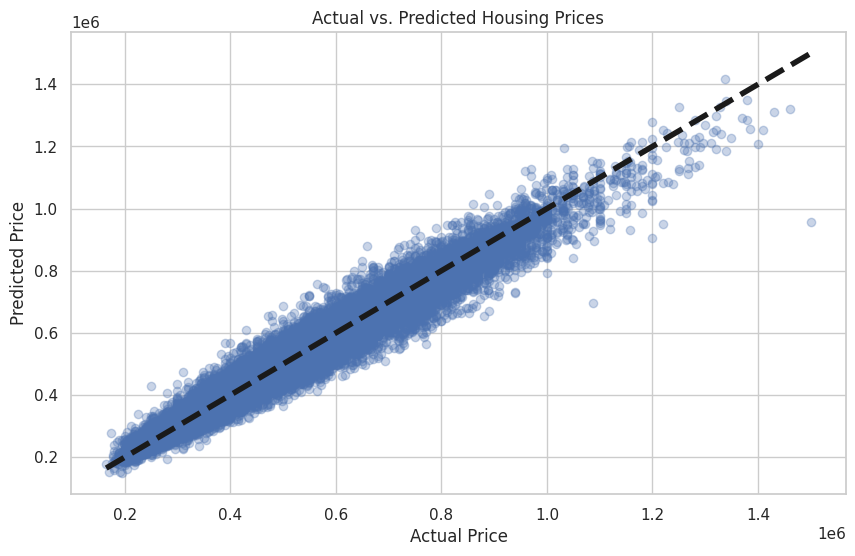

In [ ]:
# Predictive Accuracy Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Housing Prices')
plt.show()


Comparing actual vs. predicted prices on the test set, this plot visually underscores the model's predictive power and areas where it may under or overestimate values.


**Performance Metrics**:
- **RMSE**: 33,960.34 - Demonstrates the model's accuracy in dollar terms, reflecting the average prediction error.
- **R²**: 0.961 - This score indicates that 96.1% of the variance in our target variable (housing prices) is predictable from the input features.



### Conclusions

We've refined our predictive model using XGBoost with Bagging to enhance accuracy and reliability. Through hyperparameter tuning, we achieved optimal RMSE and R^2 scores, demonstrating strong model performance with reduced risk of overfitting. The final parameters balance complexity and efficiency, preparing our model for practical applications.

## Final Model Selection:

We decided to use the ARIMA model for our final goal since it has the lowest RMSE values. This is the representaion of difference between predicted value and acutual value during validation. We believed this is the most important metric for providng a robust advice to the potential buyers.

### Further Steps
Moving from modeling to application, we will now extract actionable insights from our data. The next steps involve analyzing resale price trends across towns and forecasting future price movements with ARIMA models. This analysis will guide stakeholders in making informed decisions in real estate investments and market strategies. Let’s explore these insights in detail.

# 6. Insight Implementation

In [ ]:
df_t = df_t[['town', 'resale_price']]

print(df_t.head())

                  town  resale_price
date                                
2017-01-01  ANG MO KIO      232000.0
2017-01-01  ANG MO KIO      250000.0
2017-01-01  ANG MO KIO      262000.0
2017-01-01  ANG MO KIO      265000.0
2017-01-01  ANG MO KIO      265000.0


First categorize the current average price of each town into 3, <= 560000, >560000 & <= 640000 and > 640000. The final investment recommendation will be depending on these 3 budgest ranges.

In [ ]:
df=df_t.copy()
# Step 1: Determine the last date for each town
last_dates = df.groupby('town').apply(lambda x: x.index.max())

# Step 2: Calculate the mean resale price for each town on that last date
mean_prices = df.groupby(['town', df.index]).mean().reset_index()
mean_prices_last = mean_prices[mean_prices.set_index('date').index.isin(last_dates)]

# Filter to get only the last entries
mean_prices_last = mean_prices_last[mean_prices_last['date'].isin(last_dates.values)]

# Function to categorize
def categorize_price(price):
    if price <= 560000:
        return 'cheap'
    elif price <= 640000:
        return 'medium'
    else:
        return 'expensive'

# Apply categorization
mean_prices_last['category'] = mean_prices_last['resale_price'].apply(categorize_price)

category_counts = mean_prices_last['category'].value_counts()
# Print the result
print("Counts for each category:")
print(category_counts)

Counts for each category:
category
medium       10
cheap         9
expensive     7
Name: count, dtype: int64


In [ ]:
mean_prices_last.head()

,town,date,resale_price,category
87,ANG MO KIO,2024-04-01,631633.200000,medium
175,BEDOK,2024-04-01,559414.045455,cheap
263,BISHAN,2024-04-01,781858.545455,expensive
351,BUKIT BATOK,2024-04-01,572563.030303,medium
439,BUKIT MERAH,2024-04-01,705836.366667,expensive


In [ ]:
grouped = df.groupby(['town', df.index]).mean()['resale_price'].reset_index()
grouped.set_index('date', inplace=True)
grouped.head()

,town,resale_price
date,,
2017-01-01,ANG MO KIO,413971.214286
2017-02-01,ANG MO KIO,398604.292683
2017-03-01,ANG MO KIO,436030.711111
2017-04-01,ANG MO KIO,422512.091954
2017-05-01,ANG MO KIO,443050.916667


In [ ]:
# Store results
trend = {}

# Fit an ARIMA model to each group
for town in grouped['town'].unique():
    data = grouped[grouped['town'] == town]['resale_price']
    model = ARIMA(data, order=(5,1,4))
    results = model.fit()
    forecast = results.forecast(steps=12)
    trend[town] = forecast


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used

In [ ]:
increase = {}

# Assume mean_prices_last is already filtered to contain only the last entries as you've previously defined
for cat in mean_prices_last['category'].unique():
    max_increase = None
    town_with_max_increase = None

    for town in mean_prices_last.loc[mean_prices_last['category'] == cat, 'town'].unique():
        if town in trend and len(trend[town]) > 0:
            forecast_increase = trend[town].iloc[-1] - trend[town].iloc[0]  # Difference between last and first forecasted values

            if max_increase is None or forecast_increase > max_increase:
                max_increase = forecast_increase
                town_with_max_increase = town

    if town_with_max_increase:
        increase[cat] = (town_with_max_increase, max_increase)

# Print results
for category, info in increase.items():
    print(f"Category {category}: Largest increase town in next 12 month is {info[0]} with an increase of {info[1]:.2f}")
    print(f'Current price of {info[0]} is {grouped[grouped["town"] == info[0]]["resale_price"].iloc[-1]:.2f}')

Category medium: Largest increase town in next 12 month is CENTRAL AREA with an increase of 38381.54
Current price of CENTRAL AREA is 593727.27
Category cheap: Largest increase town in next 12 month is YISHUN with an increase of 22715.73
Current price of YISHUN is 516968.72
Category expensive: Largest increase town in next 12 month is TOA PAYOH with an increase of 34230.77
Current price of TOA PAYOH is 677764.28


#7. Conclusion

In the previous analysis, we successfully deployed a data-driven approach to generate actionable insights for potential homebuyers and real estate stakeholders, focusing on understanding price trends and forecasting market movements in the Singapore housing market. We have provided a robust decision-support tool that addresses the dynamic needs of the real estate market.

Our method involved:

Filtering the latest data to focus on the most recent price categorize into—cheap, medium, and expensive. The potential buyers reference to each depending on ther budgets.


Identifying the price increase for all towns in each category in the next 12 months by emloying the ARIMA model with the same metholody dicussed before.


Highlighting specific towns that are expected to experience the highest price increases over the next 12 months, thereby guiding stakeholders in making informed investment decisions.

The findings revealed significant upcoming price increases in notable areas:

####For the cheap category, Yishun showed a notable potential increase of $22,715.73

####In the medium category, the Central Area is anticipated to see the highest rise with an increase of $38,381.54.

####In the expensive category, Toa Payoh is predicted to have an increase of $34,230.77


These insights pinpoint where significant value gains might occur, enhancing their strategic positioning in the real estate market. This analytical approach underscores our commitment to leveraging data to deliver precise, timely, and valuable insights into the Singapore housing market, ensuring that our users are well-equipped to make optimal decisions based on robust data analysis and forecasts.